In [2]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
from datetime import datetime
import pyproj

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs
import torch

import pickle

%reload_ext autoreload
%autoreload 2

from functions import *
from models import *

## Draw input & output

In [3]:
sector = "Ross"
laps = 4
c = 1
features, hidden_layers = 64, 1

files = glob.glob(f'D:\\IS2_topo_DL\\data\\Data_{sector}_*.pkl')
xx, yy, inputs, outputs = read_grid_input(files, c)

ann_input, ann_output = make_mlp_input(inputs, outputs, laps = laps)
train_input, val_input, train_output, val_output = train_test_split(ann_input, ann_output, test_size=0.3, random_state=42)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.00s/it]


Grid files are read!
MLP dataset is ready for lap time 4


In [100]:
dti = pd.date_range("2023-04-01", periods=40, freq="w")
dti

DatetimeIndex(['2023-04-02', '2023-04-09', '2023-04-16', '2023-04-23',
               '2023-04-30', '2023-05-07', '2023-05-14', '2023-05-21',
               '2023-05-28', '2023-06-04', '2023-06-11', '2023-06-18',
               '2023-06-25', '2023-07-02', '2023-07-09', '2023-07-16',
               '2023-07-23', '2023-07-30', '2023-08-06', '2023-08-13',
               '2023-08-20', '2023-08-27', '2023-09-03', '2023-09-10',
               '2023-09-17', '2023-09-24', '2023-10-01', '2023-10-08',
               '2023-10-15', '2023-10-22', '2023-10-29', '2023-11-05',
               '2023-11-12', '2023-11-19', '2023-11-26', '2023-12-03',
               '2023-12-10', '2023-12-17', '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', freq='W-SUN')

<BarContainer object of 5 artists>

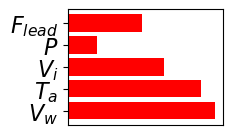

In [101]:
y=['$V_w$', '$T_a$', '$V_i$', '$P$', '$F_{lead}$']
 
# getting values against each value of y
x=[20,18,13,4,10]
plt.figure(figsize = (2,1.5))
plt.tick_params(labelsize = 16)
plt.xticks([])
plt.barh(y, x, color = "r")

(19449.0, 19722.0)

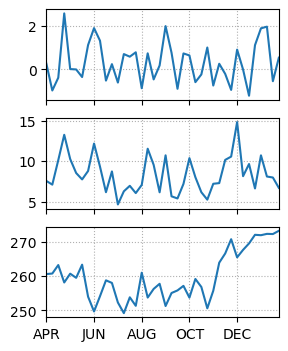

In [123]:
vmax = [+20, +20, 1, 280, +20, +20, 30, +0.05, 0.08, 1]
vmin = [-20, -20, 0, 230, -20, -20,  0, -0.05, 0.00, 0]

fig, ax = plt.subplots(3, 1, figsize = (3,4), sharex = True)
ax[0].plot(dti, inputs[:40, 4, 40, 40])
ax[1].plot(dti, inputs[:40, 6, 40, 40])
ax[2].plot(dti, inputs[:40, 3, 40, 40])
ax[2].set_xticks(dti[::8], ["APR", "JUN", "AUG", "OCT", "DEC"]);
for a in ax:
    a.grid(ls = ":")

ax[2].set_xlim(dti[0], dti[-1])

(19449.0, 19722.0)

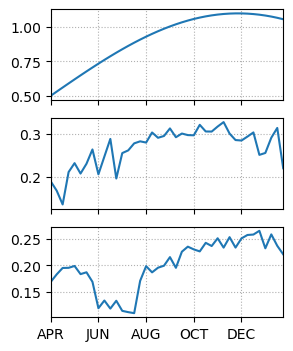

In [122]:
fig, ax = plt.subplots(3, 1, figsize = (3,4), sharex = True)
# ax[0].plot(dti, np.nanmean(outputs[80:120, 0, 20:40, 30:50], axis = (1,2)))
x = np.arange(0, len(dti)) * 0.05
y = np.sin(x)*0.6 + 0.5
ax[0].plot(dti, y)
ax[1].plot(dti, np.nanmedian(outputs[120:160, 0, 10:60, 20:50], axis = (1,2)))
ax[2].plot(dti, np.nanmedian(outputs[70:110, 0, 40:60, 30:50], axis = (1,2)))
ax[2].set_xticks(dti[::8], ["APR", "JUN", "AUG", "OCT", "DEC"]);
for a in ax:
    a.grid(ls = ":")

ax[2].set_xlim(dti[0], dti[-1])

In [103]:
dti

DatetimeIndex(['2023-04-02', '2023-04-09', '2023-04-16', '2023-04-23',
               '2023-04-30', '2023-05-07', '2023-05-14', '2023-05-21',
               '2023-05-28', '2023-06-04', '2023-06-11', '2023-06-18',
               '2023-06-25', '2023-07-02', '2023-07-09', '2023-07-16',
               '2023-07-23', '2023-07-30', '2023-08-06', '2023-08-13',
               '2023-08-20', '2023-08-27', '2023-09-03', '2023-09-10',
               '2023-09-17', '2023-09-24', '2023-10-01', '2023-10-08',
               '2023-10-15', '2023-10-22', '2023-10-29', '2023-11-05',
               '2023-11-12', '2023-11-19', '2023-11-26', '2023-12-03',
               '2023-12-10', '2023-12-17', '2023-12-24', '2023-12-31'],
              dtype='datetime64[ns]', freq='W-SUN')

In [105]:
vmax = [+20, +20, 1, 280, +20, +20, 30, +0.05, 0.08, 1]
vmin = [-20, -20, 0, 230, -20, -20,  0, -0.05, 0.00, 0]
label = ['$u_{si}$ (km/d)', '$v_{si}$ (km/d)', 'SIC (%)', 'Temp (K)', '$u_{wind}$ (m/s)',
         '$v_{wind}$ (m/s)', 'Wind gust (m/s)', 'Divergence (/day)', 'Shear (/day)']

for ind in np.arange(20, 40) + 80:
    date = datetime.strftime(d1[ind], "%Y-%m-%d")
    
    # Draw map
    fig, ax = plt.subplots(3,3, figsize = (8,7), dpi= 200,
                           subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
    plt.subplots_adjust(hspace=0.1, wspace=0.04)
    
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            c = i*3 + j
            if vmin[c] < 0:
                cmap = "RdBu"; extend = "both"
            else:
                cmap = "Blues"; extend = "neither"
            cm = ax[i,j].pcolormesh(xx, yy, inputs[ind, c], vmin = vmin[c], vmax = vmax[c], cmap = cmap)
            
            ax[i,j].coastlines('10m', linewidth = 0.5)
            ax[i,j].annotate(date, xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
            ax[i,j].annotate(label[c], xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                              linewidth=0.5, color='k', alpha = 0.5, linestyle='--')
            fig.colorbar(cm, ax = ax[i,j], orientation='horizontal', shrink = 0.5, pad = 0.05, extend = extend)
    plt.savefig(f"D:\\IS2_topo_DL\\Figures\\Ross_inputs_{date}.jpg", bbox_inches = "tight")
    # plt.close()


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000024D93D4CCA0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



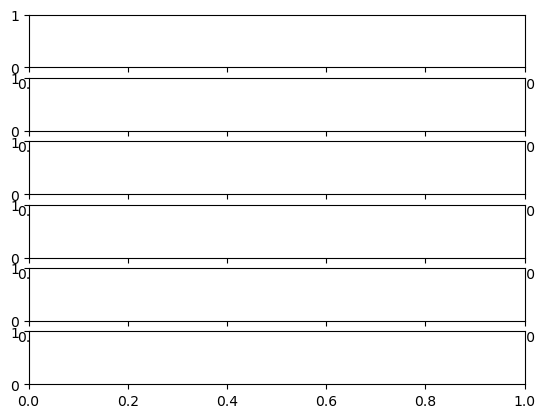

In [107]:
fig, ax = plt.subplots(6, 1)

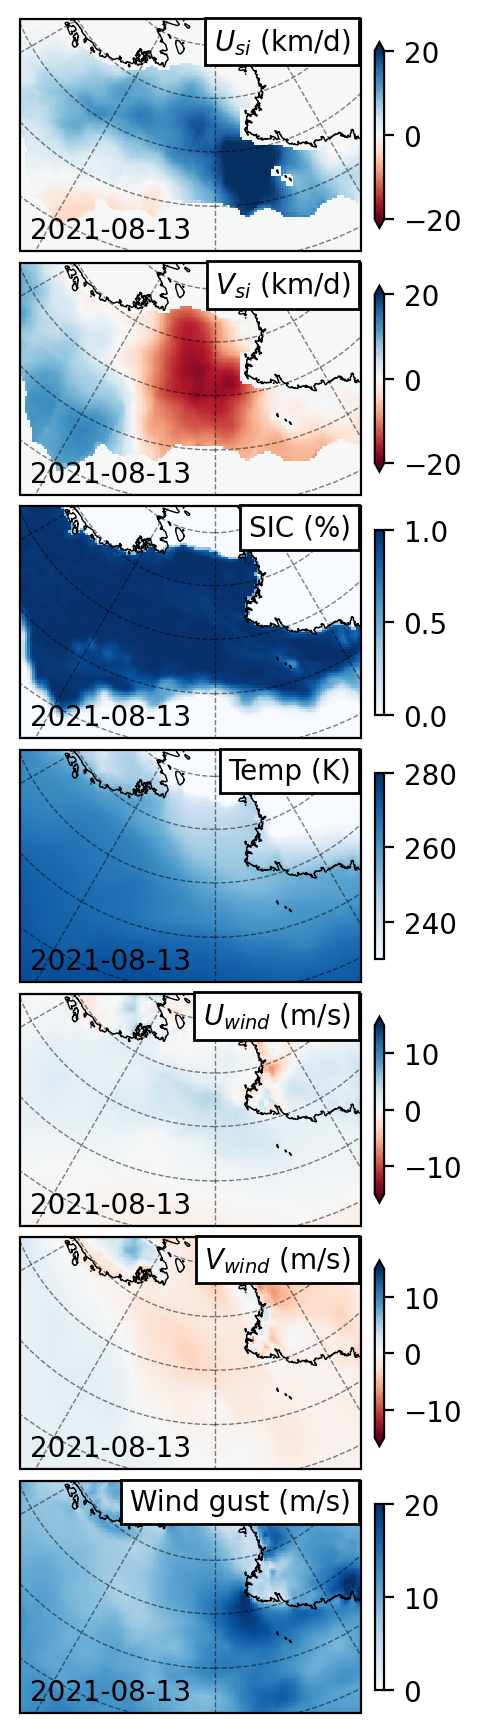

In [124]:
vmax = [+20, +20, 1, 280, +15, +15, 20, +0.05, 0.08, 1]
vmin = [-20, -20, 0, 230, -15, -15,  0, -0.05, 0.00, 0]
label = ['$U_{si}$ (km/d)', '$V_{si}$ (km/d)', 'SIC (%)', 'Temp (K)', '$U_{wind}$ (m/s)',
         '$V_{wind}$ (m/s)', 'Wind gust (m/s)', 'Divergence (/day)', 'Shear (/day)']

for ind in np.arange(20, 21) + 80:
    date = datetime.strftime(d1[ind], "%Y-%m-%d")
    
    # Draw map
    fig, ax = plt.subplots(7, 1, figsize = (3, 11), dpi= 200,
                           subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for i in range(ax.shape[0]):
        c = i
        if vmin[c] < 0:
            cmap = "RdBu"; extend = "both"
        else:
            cmap = "Blues"; extend = "neither"
        cm = ax[i].pcolormesh(xx, yy, inputs[ind, c], vmin = vmin[c], vmax = vmax[c], cmap = cmap)
        
        ax[i].coastlines('10m', linewidth = 0.5)
        ax[i].annotate(date, xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
        ax[i].annotate(label[c], xy=(0.97, 0.97), xycoords='axes fraction', fontsize=10, ha='right', va='top', bbox=dict(boxstyle="square",
                                                                                                                        fc='w', ec='k'
                   ))
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                          linewidth=0.5, color='k', alpha = 0.5, linestyle='--')
        fig.colorbar(cm, ax = ax[i], orientation='vertical', shrink = 0.8, pad = 0.03, extend = extend)
    plt.savefig(f"D:\\IS2_topo_DL\\Figures\\Ross_inputs_{date}.jpg", bbox_inches = "tight")
    # plt.close()

## IS2 Observation v. ANN Prediction
### Scatter plot

In [ ]:
sector = "Ross"
laps = 4
c = 1
features, hidden_layers = 128, 1

files = glob.glob(f'D:\\IS2_topo_DL\\data\\Data_{sector}_*.pkl')
xx, yy, inputs, outputs = read_grid_input(files, c)

ann_input, ann_output = make_mlp_input(inputs, outputs, laps = laps)
train_input, val_input, train_output, val_output = train_test_split(ann_input, ann_output, test_size=0.3, random_state=42)

ann_input = torch.tensor(ann_input, dtype=torch.float32)
ann_output = torch.tensor(ann_output, dtype=torch.float32)
train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)
val_output = torch.tensor(val_output, dtype=torch.float32)

n_samples, in_channels = val_input.size()
_, out_channels = val_output.size()

net = MLP(in_channels, out_channels, features, hidden_layers)
model_name = f"D:\\IS2_topo_DL\\model\\torch_{sector}_c{c}_lap{laps}_mlp_h{hidden_layers}_f{features}.pth"
print(model_name)

device = "cuda"
net = nn.DataParallel(net)
net.load_state_dict(torch.load(model_name, map_location=device))
net = net.to(device)
net.eval()

n_sample = val_input.shape[0]
val_pred = net(val_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = val_output.detach().numpy()
y_prd = val_pred.detach().numpy()
rmse = RMSE(y_obs, y_prd)
print(rmse)


Text(0, 0.5, '$\\sigma_f$ predicted by ANN')

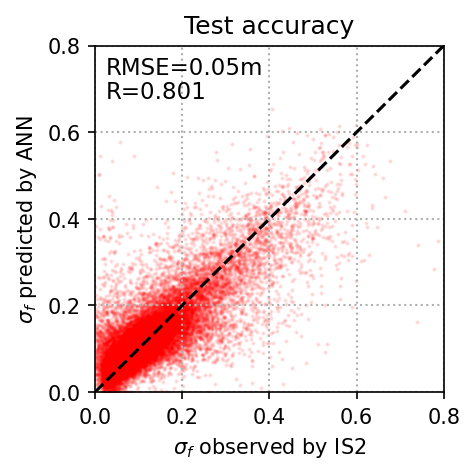

In [30]:
n_sample = val_input.shape[0]
val_pred = net(val_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = val_output.detach().numpy()
y_prd = val_pred.detach().numpy()

plt.figure(figsize = (3,3), dpi = 150)
plt.scatter(y_obs[:], y_prd[:], s = 1, alpha = 0.1, c = "r")
plt.grid(ls = ":", lw = 1)
plt.xlim(0, 0.8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.plot([0, 1], [0, 1], ls = "--", c = "k")
rmse = RMSE(y_obs, y_prd)
R = corr(y_obs, y_prd)
plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.title("Test accuracy")
plt.xlabel("$\sigma_f$ observed by IS2")
plt.ylabel("$\sigma_f$ predicted by ANN")

Text(0, 0.5, '$\\sigma_f$ predicted by ANN')

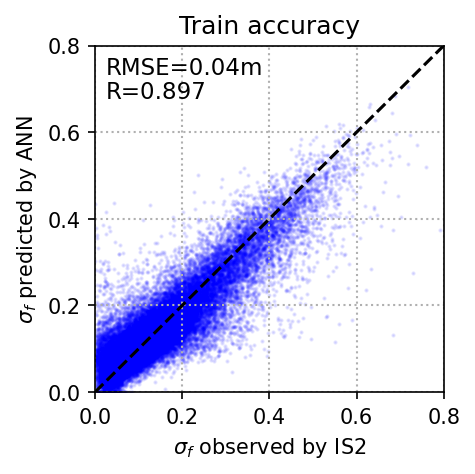

In [31]:
n_sample = train_input.shape[0]
train_pred = net(train_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = train_output.detach().numpy()
y_prd = train_pred.detach().numpy()

plt.figure(figsize = (3,3), dpi = 150)
plt.scatter(y_obs[:], y_prd[:], s = 1, alpha = 0.1, c = "b")
plt.grid(ls = ":", lw = 1)
plt.xlim(0, 0.8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.plot([0, 1], [0, 1], ls = "--", c = "k")
rmse = RMSE(y_obs, y_prd)
R = corr(y_obs, y_prd)
plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.title("Train accuracy")
plt.xlabel("$\sigma_f$ observed by IS2")
plt.ylabel("$\sigma_f$ predicted by ANN")

### Map grid

In [104]:
d1, d2 = [], []
region = "SH"
data_path = "D:\\PINN\\data"

for year in [2019, 2020, 2021, 2022]:
    ncfile = data_path + f"/{region}/Sea_ice_drift/icemotion_weekly_{region.lower()}_25km_{year}0101_{year}1231_v4.1.nc"
    ds1 = xr.open_dataset(ncfile)
    datetimeindex = ds1.time.astype("datetime64[ns]").values #ds1.indexes['time'].to_datetimeindex() #
    
    for i, d in enumerate(datetimeindex):
        if i >= 12:
            d1.append(pd.to_datetime(d) + dt.timedelta(days = 0))
            d2.append(pd.to_datetime(d) + dt.timedelta(days = 7))

is2_nc = f'D:\\IS2_topo_DL\\Ridges_density_{sector}_{year}.nc'
is2 = xr.open_dataset(is2_nc)

with netCDF4.Dataset(is2_nc, 'r') as nc:
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])

mask = (lon <= -150) | (lon > 160)

In [31]:
def draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask):
    # ANN prediction results
    date = datetime.strftime(d1[ind], "%Y-%m-%d")
    sic = inputs[ind, 2, :, :]
    valid = (sic > 0.8)
    ann_input = make_mlp_grid(inputs[ind-laps:ind+1,:9], laps = laps)
    
    ann_input = torch.tensor(ann_input, dtype=torch.float32)
    row, col = xx.shape
    
    n_samples, in_channels = ann_input.size()
    
    n_sample = ann_input.shape[0]
    ann_pred = net(ann_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)
    
    y_prd = ann_pred.detach().numpy()
    y_grid = y_prd.reshape(row, col)
    y_grid[~(valid & mask)] = np.nan
    
    # Draw map
    fig, ax = plt.subplots(1,2, figsize = (7,3), dpi= 200,
                           subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
    plt.subplots_adjust(hspace=0.04, wspace=0.04)
    
    ax[0].pcolormesh(xx, yy, outputs[ind, 1], vmin = 0, vmax = 0.5)
    ax[1].pcolormesh(xx, yy, y_grid, vmin = 0, vmax = 0.5)
    
    for i in range(0, 2):
        ax[i].coastlines('10m', linewidth = 0.5)
        ax[i].annotate(date, xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                          linewidth=0.5, color='k', alpha = 0.5, linestyle='--')
    plt.savefig(f"D:\\IS2_topo_DL\\Figures\\Ross_{date}.jpg", bbox_inches = "tight")
    plt.close()

In [33]:
for ind in np.arange(laps, 40):
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [34]:
for ind in np.arange(laps, 40) + 40:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [35]:
for ind in np.arange(laps, 40) + 80:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [36]:
for ind in np.arange(laps, 40) + 120:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

### Feature importance

In [56]:
from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance

ModuleNotFoundError: No module named 'captum'

In [57]:
ig = IntegratedGradients(net)
ig_attr_test = ig.attribute(train_input, n_steps=50)

NameError: name 'IntegratedGradients' is not defined

In [7]:
ig_attr_train_sum = ig_attr_test.detach().numpy().sum(0)

In [18]:
laps

8

0 8
8 16
16 24
24 32
32 40
40 48
48 56
56 64
64 72


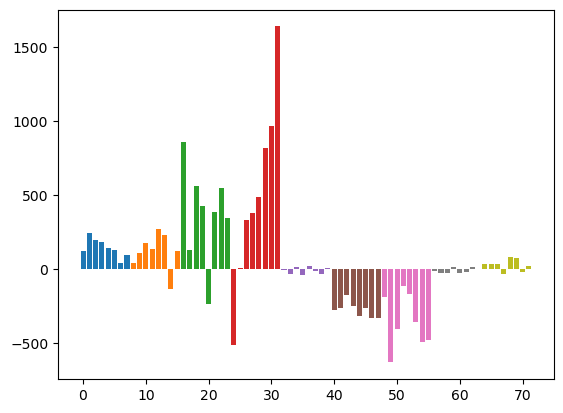

In [19]:
var_ip = 9
for i in range(var_ip):
    print(i*laps, (i+1)*laps)
    plt.bar(np.arange(i*laps, (i+1)*laps), ig_attr_train_sum[i*laps: (i+1)*laps])

In [ ]:
# grid_input[i, 0, :, :] = grid_u
# grid_input[i, 1, :, :] = grid_v
# grid_input[i, 2, :, :] = grid_sic
# grid_input[i, 3, :, :] = grid_t2m #grid_t2m - 210)/(310 - 210) #Max temp = 320 K, Min temp = 240 K)
# grid_input[i, 4, :, :] = grid_u10
# grid_input[i, 5, :, :] = grid_v10
# grid_input[i, 6, :, :] = grid_i10
# grid_input[i, 7, :, :] = np.nanmean(div, axis = 0)
# grid_input[i, 8, :, :] = np.nanmean(shr, axis = 0)

In [5]:
rng = np.random.default_rng(0)
rng.permutation(n_samples)

array([17826, 10592,  5389, ..., 22305, 27599,   607])

In [6]:
val_input

tensor([[ 0.0903, -0.2450, -0.0044,  ...,  0.0438,  0.0421,  0.0097],
        [-0.3600, -0.0398, -0.0148,  ...,  0.0516,  0.0309,  0.0533],
        [-0.1053, -0.0232, -0.1777,  ...,  0.0315,  0.0173,  0.0472],
        ...,
        [-0.0146,  0.0487,  0.1509,  ...,  0.0083,  0.0413,  0.0142],
        [ 0.4634,  0.8593,  0.1901,  ...,  0.0198,  0.0337,  0.0159],
        [ 0.2534, -0.3043,  0.3728,  ...,  0.0534,  0.0523,  0.0768]])

In [18]:
rng = np.random.default_rng(0)

#Model's val score before permutation
rmse0 = RMSE(y_obs, y_prd)

n_repeats = 50 #number of trials per feature
permutation_metrics = np.empty([in_channels, n_repeats])

#Shuffle each feature in turn, and get model's score
for i in tqdm(range(in_channels)):
    val_input_perm = val_input.clone()
    
    for repeat in range(n_repeats):
        shuffled_ixs = rng.permutation(n_samples)
        val_input_perm[:, i] = val_input[shuffled_ixs, i]

        val_pred = net(val_input_perm.to(device)).to('cpu').detach().numpy() #torch.zeros(ann_output.shape)
        
        # val_loader = DataLoader(X_val_perm, batch_size=batch_size, shuffle=True)
        permutation_metrics[i, repeat] = RMSE(y_obs, val_pred) - rmse0

    del val_input_perm, shuffled_ixs, val_pred

importance = np.mean(permutation_metrics, axis = 1)
#Convert to change in score compared to unpermuted data
# permutation_df = pd.DataFrame(permutation_metrics.T, columns=X_val.columns) - unpermuted_rmse_pct

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [01:06<00:00,  1.08it/s]


In [19]:
del val_input_perm, shuffled_ixs, val_pred

import gc
gc.collect()

0

In [ ]:
var_ip = 9
for i in range(var_ip):
    print(i*laps, (i+1)*laps)
    plt.bar(np.arange(i*laps, (i+1)*laps), importance[i*laps: (i+1)*laps])

## IS2 Observation v. LSTM Prediction
### Scatter plot

In [97]:
sector = "Ross"
laps = 4
c = 1
features, hidden_layers =128, 2

files = glob.glob(f'D:\\IS2_topo_DL\\data\\Data_{sector}_*.pkl')
xx, yy, inputs, outputs = read_grid_input(files, c)

ann_input, ann_output = make_rnn_input(inputs, outputs, laps = laps)
train_input, val_input, train_output, val_output = train_test_split(ann_input, ann_output, test_size=0.3, random_state=42)

ann_input = torch.tensor(ann_input, dtype=torch.float32)
ann_output = torch.tensor(ann_output, dtype=torch.float32)
train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)
val_output = torch.tensor(val_output, dtype=torch.float32)

n_samples, _, in_channels = val_input.size()
_, out_channels = val_output.size()

net = LSTM(in_channels, out_channels, laps=laps, features=features, hidden_layers = hidden_layers)
model_name = f"D:\\IS2_topo_DL\\model\\torch_{sector}_c{c}_lap{laps}_lstm_h{hidden_layers}_f{features}.pth"
print(model_name)

device = "cuda"
net = nn.DataParallel(net)
net.load_state_dict(torch.load(model_name, map_location=device))
net = net.to(device)
net.eval()

n_sample = val_input.shape[0]
val_pred = net(val_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = val_output.detach().numpy()
y_prd = val_pred.detach().numpy()


100%|███████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.16it/s]


Grid files are read!
RNN dataset is ready for lap time 4
D:\IS2_topo_DL\model\torch_Ross_c1_lap4_lstm_h2_f128.pth


Text(0, 0.5, '$\\sigma_f$ predicted by ANN')

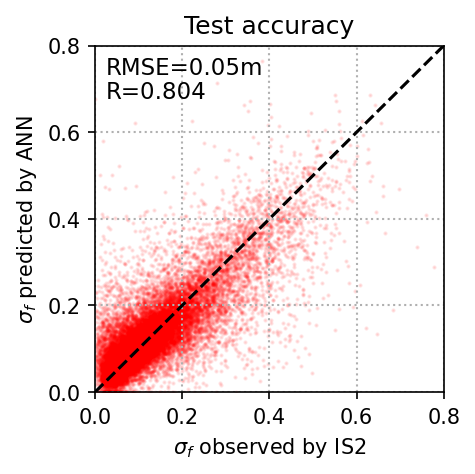

In [98]:
n_sample = val_input.shape[0]
val_pred = net(val_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = val_output.detach().numpy()
y_prd = val_pred.detach().numpy()

plt.figure(figsize = (3,3), dpi = 150)
plt.scatter(y_obs[:], y_prd[:], s = 1, alpha = 0.1, c = "r")
plt.grid(ls = ":", lw = 1)
plt.xlim(0, 0.8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.plot([0, 1], [0, 1], ls = "--", c = "k")
rmse = RMSE(y_obs, y_prd)
R = corr(y_obs, y_prd)
plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.title("Test accuracy")
plt.xlabel("$\sigma_f$ observed by IS2")
plt.ylabel("$\sigma_f$ predicted by ANN")

Text(0, 0.5, '$\\sigma_f$ predicted by ANN')

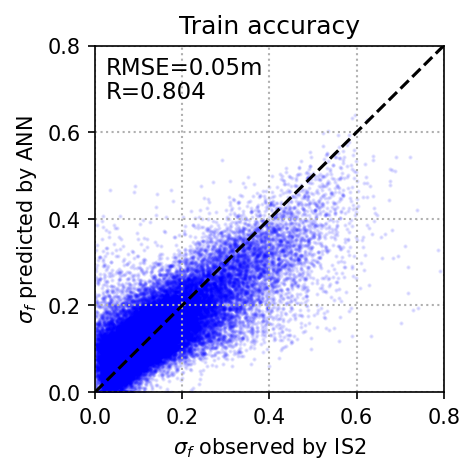

In [43]:
n_sample = train_input.shape[0]
train_pred = net(train_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)

y_obs = train_output.detach().numpy()
y_prd = train_pred.detach().numpy()

plt.figure(figsize = (3,3), dpi = 150)
plt.scatter(y_obs[:], y_prd[:], s = 1, alpha = 0.1, c = "b")
plt.grid(ls = ":", lw = 1)
plt.xlim(0, 0.8)
plt.xticks(np.arange(0, 1.0, 0.2))
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.plot([0, 1], [0, 1], ls = "--", c = "k")
rmse = RMSE(y_obs, y_prd)
R = corr(y_obs, y_prd)
plt.annotate(f"R={R:.3f}", xy=(0.03, 0.90), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.annotate(f"RMSE={rmse:.2f}m", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=11, ha='left', va='top')
plt.title("Train accuracy")
plt.xlabel("$\sigma_f$ observed by IS2")
plt.ylabel("$\sigma_f$ predicted by ANN")

### Map grid

In [32]:
d1, d2 = [], []
region = "SH"
data_path = "D:\\PINN\\data"

for year in [2019, 2020, 2021, 2022]:
    ncfile = data_path + f"/{region}/Sea_ice_drift/icemotion_weekly_{region.lower()}_25km_{year}0101_{year}1231_v4.1.nc"
    ds1 = xr.open_dataset(ncfile)
    datetimeindex = ds1.time.astype("datetime64[ns]").values #ds1.indexes['time'].to_datetimeindex() #
    
    for i, d in enumerate(datetimeindex):
        if i >= 12:
            d1.append(pd.to_datetime(d) + dt.timedelta(days = 0))
            d2.append(pd.to_datetime(d) + dt.timedelta(days = 7))

is2_nc = f'D:\\IS2_topo_DL\\Ridges_density_{sector}_{year}.nc'
is2 = xr.open_dataset(is2_nc)

with netCDF4.Dataset(is2_nc, 'r') as nc:
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])

mask = (lon <= -150) | (lon > 160)

In [47]:
def draw_rnn_map(inputs, outputs, ind, d1, xx, yy, net, device, mask):
    # ANN prediction results
    date = datetime.strftime(d1[ind], "%Y-%m-%d")
    sic = inputs[ind, 2, :, :]
    valid = (sic > 0.8)
    ann_input = make_rnn_grid(inputs[ind-laps:ind+1,:9], laps = laps)
    
    ann_input = torch.tensor(ann_input, dtype=torch.float32)
    row, col = xx.shape
    
    n_samples, _, in_channels = ann_input.size()
    
    n_sample = ann_input.shape[0]
    ann_pred = net(ann_input.to(device)).to('cpu') #torch.zeros(ann_output.shape)
    
    y_prd = ann_pred.detach().numpy()
    y_grid = y_prd.reshape(row, col)
    y_grid[~(valid & mask)] = np.nan
    
    # Draw map
    fig, ax = plt.subplots(1,2, figsize = (7,3), dpi= 200,
                           subplot_kw={'projection': ccrs.SouthPolarStereo(true_scale_latitude = -70)})
    plt.subplots_adjust(hspace=0.04, wspace=0.04)
    
    ax[0].pcolormesh(xx, yy, outputs[ind, 0], vmin = 0, vmax = 0.5)
    ax[1].pcolormesh(xx, yy, y_grid, vmin = 0, vmax = 0.5)
    
    for i in range(0, 2):
        ax[i].coastlines('10m', linewidth = 0.5)
        ax[i].annotate(date, xy=(0.03, 0.03), xycoords='axes fraction', fontsize=10, ha='left', va='bottom')
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          xlocs = np.arange(-180, 180, 30), ylocs=  np.arange(-90, 90, 5),
                          linewidth=0.5, color='k', alpha = 0.5, linestyle='--')
    plt.savefig(f"D:\\IS2_topo_DL\\Figures\\RNN_Ross_{date}.jpg", bbox_inches = "tight")
    plt.close()

In [48]:
for ind in np.arange(laps, 40):
    draw_rnn_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [34]:
for ind in np.arange(laps, 40) + 40:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [35]:
for ind in np.arange(laps, 40) + 80:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

In [36]:
for ind in np.arange(laps, 40) + 120:
    draw_ann_map(inputs, outputs, ind, d1, xx, yy, net, device, mask)

### Feature importance

In [45]:
val_input.shape

torch.Size([29026, 4, 9])

In [51]:
val_input_perm.shape

torch.Size([29026, 4, 9])

In [52]:
y_obs.shape

(29026, 1)

In [53]:
rng = np.random.default_rng(0)

#Model's val score before permutation
rmse0 = RMSE(y_obs, y_prd)

n_repeats = 10 #number of trials per feature
permutation_metrics = np.empty([in_channels, laps, n_repeats])

batch_size = 32
#Shuffle each feature in turn, and get model's score
for i in tqdm(range(in_channels)):
    for j in range(laps):
        val_input_perm = val_input.clone()
        
        for repeat in range(n_repeats):
            shuffled_ixs = rng.permutation(n_samples)
            val_input_perm[:, j, i] = val_input[shuffled_ixs, j, i]
            
            # val_pred = np.zeros(y_obs.shape)    
            # for n in range(0, n_samples, batch_size):
            #     val_pred[n:n+batch_size] = net(val_input_perm[n:n+batch_size].to(device)).to('cpu').detach().numpy()
    
            val_pred = net(val_input_perm.to(device)).to('cpu').detach().numpy() #torch.zeros(ann_output.shape)
            
            # val_loader = DataLoader(X_val_perm, batch_size=batch_size, shuffle=True)
            permutation_metrics[i, j, repeat] = RMSE(y_obs, val_pred) - rmse0
    
        del val_input_perm, shuffled_ixs, val_pred

importance = np.mean(permutation_metrics, axis = 2)
#Convert to change in score compared to unpermuted data
# permutation_df = pd.DataFrame(permutation_metrics.T, columns=X_val.columns) - unpermuted_rmse_pct

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.27s/it]


In [59]:
importance

array([[0.01746255, 0.017691  , 0.0167635 , 0.01707321],
       [0.01531327, 0.01656177, 0.01592675, 0.00962104],
       [0.00590425, 0.00270367, 0.00125042, 0.0008409 ],
       [0.00881688, 0.00639014, 0.00443572, 0.00389762],
       [0.00759768, 0.00724074, 0.00608564, 0.00658462],
       [0.00900631, 0.00902574, 0.00646406, 0.00436811],
       [0.00616361, 0.00469747, 0.00449304, 0.00242978],
       [0.00214495, 0.00191751, 0.00180329, 0.00108487],
       [0.00111581, 0.00089225, 0.00070398, 0.00045803]])

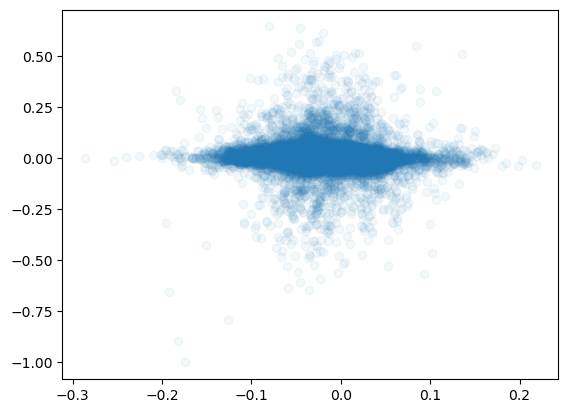

In [54]:
plt.scatter(val_input[:, 0, 4], val_input[:, 0, 7], alpha = 0.05)

In [ ]:
# grid_input[i, 0, :, :] = grid_u
# grid_input[i, 1, :, :] = grid_v
# grid_input[i, 2, :, :] = grid_sic
# grid_input[i, 3, :, :] = grid_t2m #grid_t2m - 210)/(310 - 210) #Max temp = 320 K, Min temp = 240 K)
# grid_input[i, 4, :, :] = grid_u10
# grid_input[i, 5, :, :] = grid_v10
# grid_input[i, 6, :, :] = grid_i10
# grid_input[i, 7, :, :] = np.nanmean(div, axis = 0)
# grid_input[i, 8, :, :] = np.nanmean(shr, axis = 0)

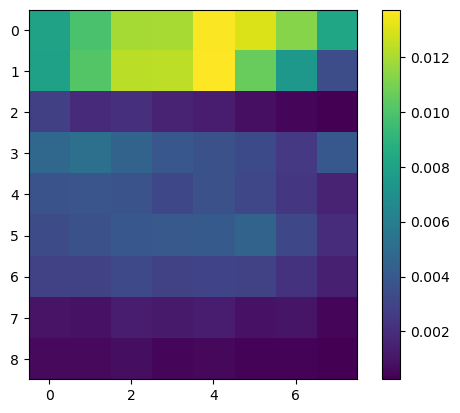

In [45]:
plt.imshow(importance)
plt.colorbar()

In [68]:
np.arange(i*laps, (i+1)*laps)

array([0, 1, 2, 3])

(0.0, 0.02)

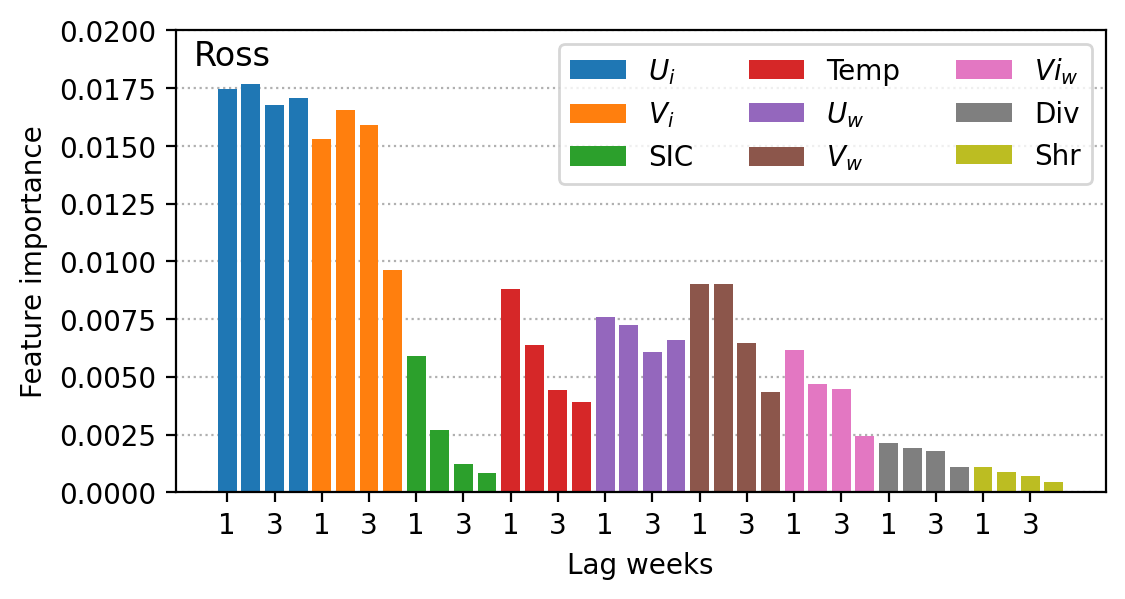

In [96]:
plt.figure(figsize = (6, 3), dpi = 200)

var_ip = 9
labels = ["$U_{i}$", "$V_{i}$", "SIC", "Temp", "$U_{w}$", "$V_{w}$", "$Vi_{w}$", "Div", "Shr"]

# grid_input[i, 0, :, :] = grid_u
# grid_input[i, 1, :, :] = grid_v
# grid_input[i, 2, :, :] = grid_sic
# grid_input[i, 3, :, :] = grid_t2m #grid_t2m - 210)/(310 - 210) #Max temp = 320 K, Min temp = 240 K)
# grid_input[i, 4, :, :] = grid_u10
# grid_input[i, 5, :, :] = grid_v10
# grid_input[i, 6, :, :] = grid_i10
# grid_input[i, 7, :, :] = np.nanmean(div, axis = 0)
# grid_input[i, 8, :, :] = np.nanmean(shr, axis = 0)

xt = []
xt_label = []

for i in range(var_ip):
    # print(i*laps, (i+1)*laps)
    plt.bar(np.arange(i*laps, (i+1)*laps), importance[i], label = labels[i], zorder = 2)
    for k, n in enumerate(np.arange(i*laps, (i+1)*laps)):
        if k % 2 == 0:
            xt.append(n)
            xt_label.append(str(k+1))
    # plt.bar(np.arange(i*laps, (i+1)*laps), ig_attr_train_sum[i*laps: (i+1)*laps])

plt.xticks(xt, xt_label)
plt.legend(ncol = 3)
plt.grid(ls = ":", zorder = 0, axis = "y")
plt.ylabel("Feature importance")
plt.xlabel("Lag weeks")
plt.annotate(sector, xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, ha='left', va='top', zorder = 5)
plt.ylim(0, 0.02)